# Step 1: Importing Libraries

In [152]:
# data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# text preprocessing
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import string

# modeling
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from  sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report,confusion_matrix, ConfusionMatrixDisplay




# Step 2: Load and Prepare Dataset

In [2]:
# Load Dataset
df = pd.read_csv("data/Restaurant_Reviews.tsv", sep='\t')
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [3]:
# rename columns
df.columns = ['text','label']
df.head()

,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [5]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
df.duplicated().sum() 

4

In [7]:
df = df.drop_duplicates(keep='first')
df.shape

(996, 2)

# Step 3: Visualizing Text Data

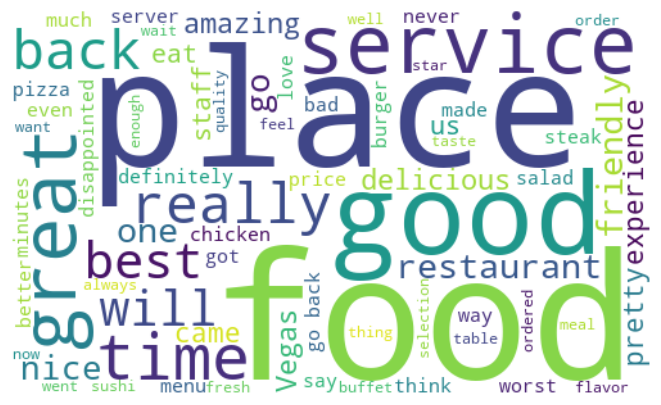

In [8]:
# Generate Word Cloud
wordcloud = WordCloud(width=500, height=300, background_color='white', min_font_size=10).generate(' '.join(df['text']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [52]:
count=df['label'].value_counts(normalize='true')*100
count

label
1    50.100402
0    49.899598
Name: proportion, dtype: float64

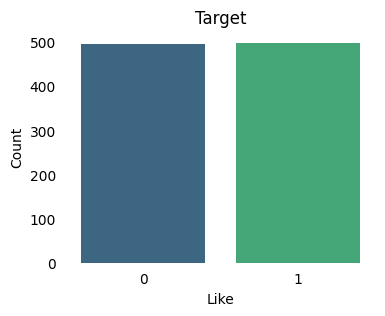

In [10]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(4,3))
ax.tick_params(left=False, bottom=False) # Remove ticks
sns.despine(left=True, bottom=True) # Remove borders borders

# define order the graph but also only showing top 25 rows
sns.countplot(df, x='label',palette='viridis', hue='label',legend=False)
plt.title("Target", fontsize=12)
plt.ylabel("Count")
plt.xlabel("Like")
plt.xticks(
            # rotation=45, 
            ha='center')
plt.show()

# Step 4: Data Preprocessing

In [53]:
# Helper function to map NLTK POS tags to WordNet POS tags
def get_pos_tag(tag):
    pos_map = {
        'NN': 'n', 'NNS': 'n', 'NNP': 'n', 'NNPS': 'n',
        'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',
        'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
        'RB': 'r', 'RBR': 'r', 'RBS': 'r'
    }
    return pos_map.get(tag, 'n')  # Default to noun if tag is not found

In [45]:
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers

    # Tokenize text into words and POS tags
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)

    # Lemmatize words based on POS tags
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos=get_pos_tag(tag)) for word, tag in tagged_tokens]

    # Remove stopwords
    filtered_tokens = [word for word in lemmatized_tokens if word not in set(stopwords.words('english'))]

    # Join tokens back into a string
    text = ' '.join(filtered_tokens)

    return text


In [ ]:
# Apply Preprocessing
df['text'] = df['text'].apply(preprocess_text)

In [46]:
df.head()

,text,label
0,wow love place,1
1,crust good,0
2,tasty texture nasty,0
3,stop late may bank holiday rick steve recommen...,1
4,selection menu great price,1


# Step 5: Feature Extraction

In [47]:
# Convert Text Data into Vectors
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])
y = df['label']

In [49]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Model Training and Evaluation

In [174]:
def evaluate_models(models, X_train, y_train, X_test, y_test, param_grid_dict, choose_score='accuracy'):
    """
    Evaluates a dictionary of models with hyperparameter tuning (optional) and outputs a table of results.
    Also pickles the model with the highest chosen score (accuracy, precision, or recall).

    Args:
        models (dict): A dictionary where keys are model names and values are scikit-learn models.
        X_train (array): Training data.
        y_train (array): Training labels.
        X_test (array): Testing data.
        y_test (array): Testing labels.
        param_grid_dict (dict, optional): A dictionary where keys are model names and
                                          values are dictionaries defining the hyperparameter grid for GridSearchCV.
                                          Defaults to None.
        choose_score (str, optional): The metric to use for selecting the best model for pickling.
                                      Options: 'accuracy', 'precision', 'recall'. Defaults to 'accuracy'.

    Returns:
        pandas.DataFrame: A DataFrame containing the evaluation results, including best hyperparameters if tuning was performed.
    """

    results = []
    path = 'models/'  # Path to save pickled models

    best_model = None
    best_score = 0  # Initialize with negative infinity

    for name, model in models.items():
        if param_grid_dict is not None and name in param_grid_dict:
            # Perform hyperparameter tuning with GridSearchCV
            grid_search = GridSearchCV(model, param_grid_dict[name], scoring=choose_score, cv=5)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            best_params = grid_search.best_params_
        else:
            model.fit(X_train, y_train)
            best_params = None

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        results.append({
            'model name': name,
            'best hyperparameters': best_params,
            'accuracy': f'{accuracy:.4f}',
            'precision': f'{precision:.4f}',
            'recall': f'{recall:.4f}'
        })     

        # Get the metric value based on chosen score
        metric_score = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall
        }[choose_score]

        # Update best model and score if current score is higher
        if metric_score > best_score:
            best_model = model
            best_name = name
            best_score = metric_score
            best_params = best_params        

        df = pd.DataFrame(results)
        df = df.sort_values(choose_score, ascending=False)

    # Pickle the trained model
    with open(path + 'model' + '.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    
    if best_model is not None:
        # Print results only for the best model
            y_pred = best_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            cm = confusion_matrix(y_test, y_pred)

            print(f"\n--- Best Model Results ---\n")
            print(f"Best Model Name: {best_name}")
            print(f"{choose_score}: {best_score:.4f}")
            print(f"Best Hyperparameters: {best_params}")

            
            print(f"\nConfusion Matrix Results" ) 
            print("True Positives:", cm[1,1])
            print("True Negatives:", cm[0, 0])
            print("False Positives (Type I error):", cm[0, 1],'(where a true negative was incorrectly predicted as positive)')
            print("False Negatives (Type II error):", cm[1, 0], '(where a true positive was incorrectly predicted as negative)') 

    # Save the master results table (unchanged)
    df.to_csv(path + 'results_table.csv', index=False)
    
    print('------------------------')
    print('\nMODEL SUMMARY')
    return df

In [175]:
# Fit models
models = {
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'K Neighbors': KNeighborsClassifier()
}

# Define hyperparameter grids 
param_grid_dict = {
    'Decision Tree': {
        'max_depth': [2, 4, 6],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [2, 4, 6]
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'minkowski', 'manhattan']
    }
}

evaluate_models(models, X_train, y_train, X_test, y_test, param_grid_dict,choose_score='precision')


--- Best Model Results ---

Best Model Name: Logistic Regression
precision: 0.7723
Best Hyperparameters: None

Confusion Matrix Results
True Positives: 65
True Negatives: 89
False Positives (Type I error): 17 (where a true negative was incorrectly predicted as positive)
False Negatives (Type II error): 29 (where a true positive was incorrectly predicted as negative)
------------------------

MODEL SUMMARY


,model name,best hyperparameters,accuracy,precision,recall
3,Logistic Regression,None,0.7700,0.7723,0.7700
0,Naive Bayes,None,0.7700,0.7701,0.7700
2,Random Forest,"{'max_depth': 6, 'n_estimators': 200}",0.7100,0.7356,0.7100
4,K Neighbors,None,0.7200,0.7212,0.7200
1,Decision Tree,"{'max_depth': 2, 'min_samples_split': 2}",0.6150,0.6924,0.6150
